In [1]:
import os
import random
from time import time
import pandas as pd
import numpy as np
import networkx as nx
import graph_tool.all as gt
from motif_counts import *
from tqdm.auto import tqdm
from collections import defaultdict
from collections import defaultdict
from tqdm import tqdm
from joblib import Parallel, delayed
import pickle
#from tqdm.notebook import tqdm

In [22]:
keys_to_remove = [1, 2,3]

for k in keys_to_remove:
    motifs.pop(k, None) 

#
# 1) Grab the sorted list of remaining old keys
old_keys = sorted(motifs.keys())

# 2) Build a mapping old→new
old_to_new = { old: new for new, old in enumerate(old_keys, start=1) }

# 3) Re-index motifs, exp_counts, obs_counts
motifs      = { old_to_new[old]: motifs[old]      for old in old_keys }

In [2]:
df = pd.read_feather('mcns_fw_edge_comp.feather')

In [3]:
# 1) build a unique list of all node labels
labels = np.unique(np.concatenate([df['pre'].values, df['post'].values]))

# 2) create the graph and a string vertex‐property to store the label
g = gt.Graph(directed=True)
v_label = g.new_vp("string")
g.vp["label"] = v_label

# 3) add one vertex per label, keep a Python dict to map label→vertex
label2v = {}
for L in labels:
    v = g.add_vertex()
    label2v[L] = v
    v_label[v] = str(L)

# 4) create a float edge‐property for your weights
e_weight = g.new_ep("float")
g.ep["weight"] = e_weight

# 5) add all edges with their weights
edge_list = [
    (label2v[src], label2v[tgt], float(w))
    for src, tgt, w in df[['pre','post','weight_m']].itertuples(index=False)
]
g.add_edge_list(edge_list, eprops=[g.ep["weight"]])
loops = [e for e in g.edges() if e.source() == e.target()]
for e in loops:
    g.remove_edge(e)

In [23]:
import networkx as nx

nxg = nx.DiGraph()

# 2) Add all nodes (we’ll keep the original integer IDs)
for v in g.vertices():
    vid = int(v)        # graph-tool uses Vertex objects, cast to int
    nxg.add_node(vid)
    
# 3) Add all directed edges
for e in g.edges():
    src = int(e.source())
    tgt = int(e.target())
    nxg.add_edge(src, tgt)

# 4) Now call your motif routines on the NX graph
triplet_pr, pair_pr = compute_three_neuron_motif_probabilities(nxg)
exp_counts     = compute_expected_three_neuron_motifs(nxg, triplet_pr)

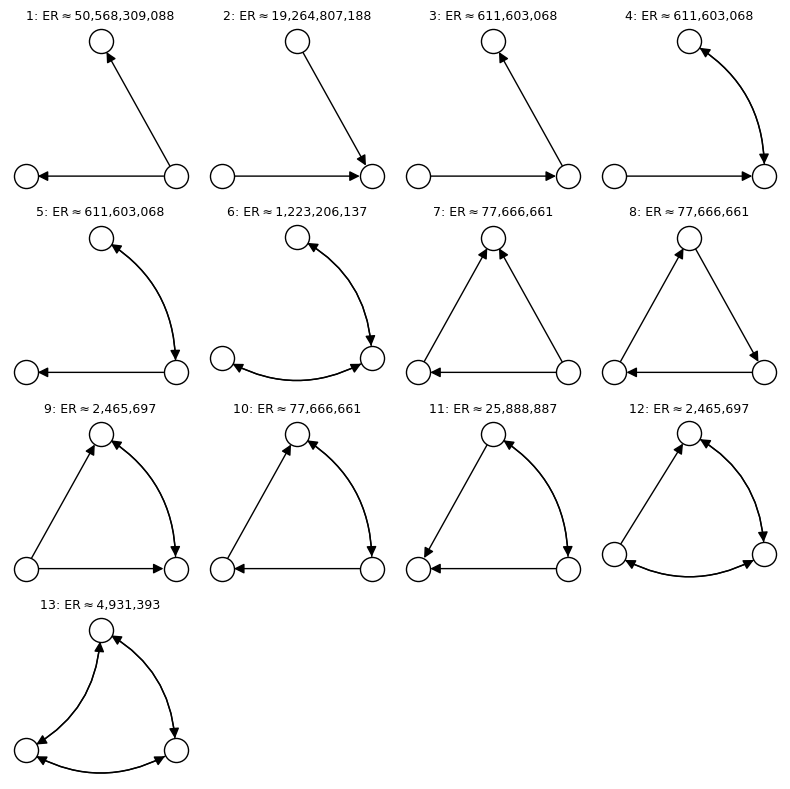

In [21]:
import matplotlib.pyplot as plt
import networkx as nx

# your exp_counts: motif_id → expected count (float or int)
# e.g. exp_counts = {1: 50568309088.48, 2: 19264807187.62, …}

# fixed triangle layout


pos = {
    0: (0.0, 0.0),
    1: (1.0, 0.0),
    2: (0.5, 0.866)
}

def plot_triplet_with_exp(triplet, motif_id, exp_counts, ax):
    # build a tiny DiGraph
    G = nx.DiGraph()
    G.add_nodes_from([0,1,2])
    edges = triplet.get_edges()
    G.add_edges_from(edges)
    
    # draw nodes
    nx.draw_networkx_nodes(
        G, pos, ax=ax,
        node_size=300,
        node_color='white',
        edgecolors='black'
    )
    
    # draw edges (curved if reciprocal)
    for u, v in edges:
        if (v, u) in edges:
            rad = 0.3 if u < v else -0.3
            nx.draw_networkx_edges(
                G, pos, edgelist=[(u,v)], ax=ax,
                arrowstyle='-|>',
                arrowsize=15,
                connectionstyle=f'arc3,rad={rad}'
            )
        else:
            nx.draw_networkx_edges(
                G, pos, edgelist=[(u,v)], ax=ax,
                arrowstyle='-|>',
                arrowsize=15
            )

    ax.set_axis_off()
    # title with motif ID and formatted expected count
    ec = exp_counts.get(motif_id, float('nan'))
    ax.set_title(f"{motif_id}: ER ≈ {ec:,.0f}", fontsize=9)

# layout grid
cols = 4
rows = (len(motifs) + cols - 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(cols*2, rows*2))
axes = axes.flatten()

# plot each motif
for ax, (mid, tri) in zip(axes, motifs.items()):
    plot_triplet_with_exp(tri, mid, exp_counts, ax)

# hide any extra axes
for ax in axes[len(motifs):]:
    ax.set_visible(False)

plt.tight_layout()
plt.show()
